# EDA and Budget selection

In [21]:
import sys
sys.path.append(str('/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/'))

from configparser import ConfigParser

from repo.MyConfigParser import MyConfigParser

from repo.LoadData import DataLoader
from repo.BuildModel import GenerateModelFile, CreateModel
from repo.Accuracy import AccuracyCalculator, ProphetParameterSearch, PlotAccuracyCharts
from repo.FileGenerator import *

import matplotlib.pyplot as plt
import pandas as pd

In [22]:
pd.set_option('display.float_format', '{:.6f}'.format)

In [23]:
updated_config = ConfigParser()
config_in_path = "/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/mx/1 June Update/config ups mx.ini"
updated_config.read(config_in_path)

getdict = MyConfigParser()
config_dict=getdict.GetDict(updated_config)
region = config_dict['CLIENTINFO']['country']
cutoff_month = config_dict['PROPHETSETTING']['cut_off_point']
base_start = config_dict['PROPHETSETTING']['reference_start_date1']
base_end = config_dict['PROPHETSETTING']['reference_end_date1']
periods = config_dict['PROPHETSETTING']['periods']
base_periods  = config_dict['PROPHETSETTING']['base_periods']

training_query = config_dict["PROPHETSETTING"]["training_query"]
_input = config_dict["PROPHETSETTING"]["input"]
_output = config_dict["PROPHETSETTING"]["output"]

output_bucket = config_dict["FILEPATH"]["output_bucket"]
folder_name = config_dict["FILEPATH"]["folder_name"]


today = datetime.date.today().strftime("%m.%d.%Y") #'03.10.2023' #
print(today)
base_path = config_dict["FILEPATH"]["base_path"]

boundary_df_in_path = base_path + config_dict["FILEPATH"]["boundary_df_in_path"]
daily_df_out_path = base_path + config_dict["FILEPATH"]["daily_df_out_path"]
analytical_file_path = base_path + config_dict["FILEPATH"]["analytical_file_path"]
cuts_df_in_path = base_path + config_dict["FILEPATH"]["cuts_df_in_path"]
plot_name = base_path + config_dict["FILEPATH"]["plot_name"]
constraint_file_name = base_path + config_dict["FILEPATH"]["constraint_file_name"]

05.30.2024


In [24]:
daily_df = GetBQData(training_query, _input, _output)
daily_df.ds = pd.to_datetime(daily_df.ds) # ensure ds is date_time type
daily_df['day'] = daily_df.ds.dt.day
daily_df['month'] = daily_df.ds.dt.month
daily_df['year'] = daily_df.ds.dt.year

/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/QueryingData.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  search_df.fillna(method = 'ffill', inplace = True)


In [25]:
daily_df.market.unique()

array(['Mexico'], dtype=object)

In [6]:
year_2022 = daily_df.loc[(daily_df['ds'] >= '2022-04-28') & (daily_df['ds'] <= '2022-06-04'), 'X'].sum()
year_2023 = daily_df.loc[(daily_df['ds'] >= '2023-04-27') & (daily_df['ds'] <= '2023-06-03'), 'X'].sum()
pre_optimization_budget = (year_2022 + year_2023) / 2

In [7]:
pre_optimization_budget

14704.32

In [26]:
df = daily_df.copy()

In [27]:
df.loc[df['funnel'] != 'Brand', 'funnel'] = 'Non_Brand'
df = df.groupby(['region', 'market', 'funnel', 'ds','day','month','year'])[['X', 'y']].sum().reset_index()

In [28]:
df = df[~df[['ds', 'y']].isin([np.nan, np.inf, -np.inf]).any(axis=1)]

In [29]:
df.to_csv('df.csv', index=False)

In [30]:
df_filtered_plot = df.loc[(df['funnel']=='Brand')].copy()
df_filtered_plot['year_month'] = df_filtered_plot.ds.dt.strftime('%Y-%m')
df_filtered_plot = df_filtered_plot.groupby(['market','year_month']).sum(numeric_only=True).reset_index()

/var/tmp/ipykernel_84038/2729590374.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df_filtered_plot['year_month'].astype(str), rotation=90)


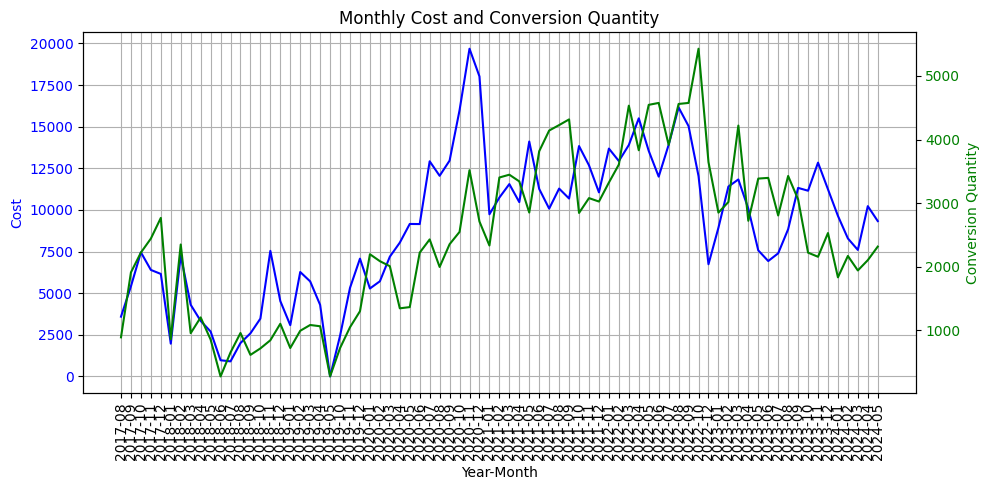

In [49]:

fig, ax1 = plt.subplots(figsize=(10, 5))


ax1.plot(df_filtered_plot['year_month'].astype(str), df_filtered_plot['X'], color='b', label='Cost')
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Cost', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Monthly Cost and Conversion Quantity')
ax1.grid(True)
ax1.set_xticklabels(df_filtered_plot['year_month'].astype(str), rotation=90)


ax2 = ax1.twinx()
ax2.plot(df_filtered_plot['year_month'].astype(str), df_filtered_plot['y'], color='g', label='Conversion Quantity')
ax2.set_ylabel('Conversion Quantity', color='g')
ax2.tick_params(axis='y', labelcolor='g')

fig.tight_layout()


plt.show()


In [18]:
df_plot = df.loc[(df['funnel']=='Brand')].copy()
df_plot['year_month'] = df_plot.ds.dt.strftime('%Y-%m')
year_2023 = df_plot.loc[(df_plot['year_month'] >= '2023-01') & (df_plot['year_month'] <= '2023-12'), ['market','X','y','month','day','year','funnel','ds','year_month']]
year_2023 = year_2023.groupby(['market','year_month']).sum(numeric_only=True).reset_index()

In [14]:
df_plot=df_plot.groupby(['market','ds']).sum(numeric_only=True).reset_index()

/var/tmp/ipykernel_85082/21983855.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(year_2023_grouped['year_month'].astype(str), rotation=90)


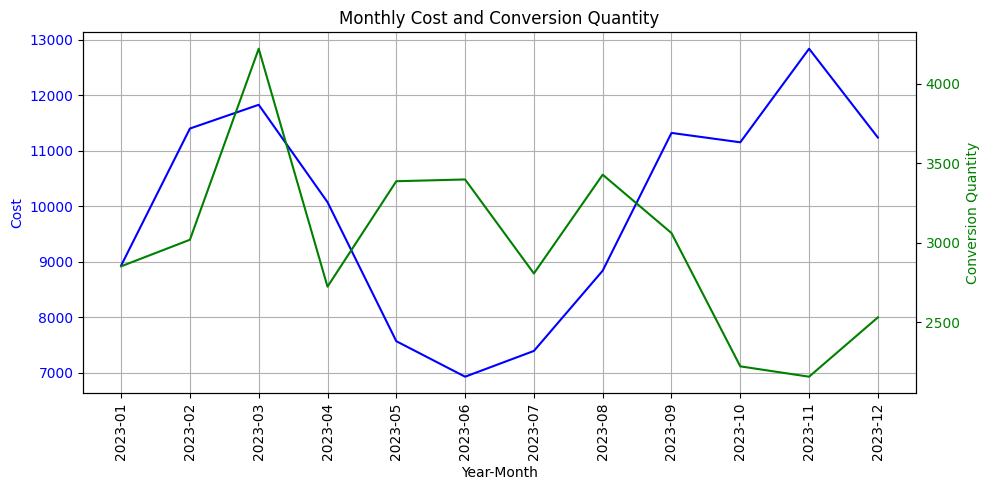

In [31]:
# Filtra el DataFrame para 'Brand'
df_plot = df.loc[df['funnel'] == 'Brand'].copy()
df_plot['year_month'] = df_plot['ds'].dt.strftime('%Y-%m')

# Filtra para el año 2023 y selecciona las columnas necesarias
year_2023 = df_plot.loc[(df_plot['year_month'] >= '2023-01') & (df_plot['year_month'] <= '2023-12')]

# Agrupa por 'market' y 'year_month' y suma las columnas numéricas
year_2023_grouped = year_2023.groupby(['market', 'year_month']).sum(numeric_only=True).reset_index()

# Crea la figura y los ejes para la gráfica
fig, ax1 = plt.subplots(figsize=(10, 5))

# Grafica el costo en el primer eje y
ax1.plot(year_2023_grouped['year_month'].astype(str), year_2023_grouped['X'], color='b', label='Cost')
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Cost', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Monthly Cost and Conversion Quantity')
ax1.grid(True)
ax1.set_xticklabels(year_2023_grouped['year_month'].astype(str), rotation=90)

# Crea un segundo eje y para la cantidad de conversiones
ax2 = ax1.twinx()
ax2.plot(year_2023_grouped['year_month'].astype(str), year_2023_grouped['y'], color='g', label='Conversion Quantity')
ax2.set_ylabel('Conversion Quantity', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Ajusta el layout de la figura
fig.tight_layout()

# Muestra la gráfica
plt.show()
